# 0. Introduction

## 0.1. What is Gammapy?

Gammapy is an open-source Python package for gamma-ray astronomy. It is used as a core library for the 
Science Analysis tools of the Cherenkov Telescope Array (CTA). By now, it is also used by other Imaging Atmospheric Cherenkov Telescope (IACT) facilities such as MAGIC, VERITAS and H.E.S.S. and by Water Cherenkov Detectors (WCD) such as HAWC.

![gammapy](figures/gammapy_package.png)

## 0.2. The dataset of the hands-on sessions

In the following Jupyter notebooks, we will analyse public data of the standard source at VHE gamma rays, the Crab Nebula. The notebooks also contain code to produce a light curve (LC) for the blazar PKS 2155-304, to be discussed if there is time, or you can go through it by yourself after the course, when you should have the tools and knowledge to produce an LC by yourself.

## 0.3. H.E.S.S.

[H.E.S.S.](https://www.mpi-hd.mpg.de/hfm/HESS/) is an array of 5 gamma-ray telescopes located in Namibia. The H.E.S.S. data is private, and H.E.S.S. analysis is mostly documented and discussed in the internal communication channels. However, in 2018, a small sub-set of archival H.E.S.S. data was publicly released, called the [H.E.S.S. DL3 DR1](https://www.mpi-hd.mpg.de/hfm/HESS/pages/dl3-dr1/), the data level 3, data release number 1. This is the observational data we will be using. The dataset contains observations of various sources with different types, such as a blazar, a pulsar wind nebula and a supernova remnant. You can check which observation (id) belongs to which source on the last three pages of [this](https://www.mpi-hd.mpg.de/HESS/pages/dl3-dr1/hess_dl3_dr1.pdf) document.

## 0.4. MAGIC

[MAGIC](https://magic.mpp.mpg.de/) are two IACTs on the canary island of La Palma, observing together in stereo mode since 2009. As for H.E.S.S., the data is private and is mostly analysed with a proprietary software, although it is possible to do a high-level analysis with Gammapy. Only recently the experiment has publicly released few observations of the Crab Nebula. We will not use these during the course but you may try solving the excercises at home, in which case you will also play with MAGIC data a bit.

# 1. IACT data exploration

Let us now examine the data from H.E.S.S., a pointing instrument.

In [46]:
# - basic dependencies (numpy, astropy, regions, matplotlib)
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import PointSkyRegion, CircleSkyRegion, RectangleSkyRegion
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# - Gammapy dependencies
from gammapy.data import EventList, Observation, DataStore
from gammapy.maps import Map, MapAxis
from gammapy.stats import WStatCountsStatistic
from gammapy.makers.utils import make_theta_squared_table
from gammapy.visualization import plot_theta_squared_table

## 1.1. Event lists

The so-called event list, is one of the two fundamental parts of high-level gamma-ray data, as it contains fundamental observables of the events classified as gamma-rays (energy, coordinates, arrival time, etc...) that are essential for any astronomical or physical analysis.

In [47]:
events = EventList.read(
    "data/hess-dl3-dr1/data/hess_dl3_dr1_obs_id_023523.fits.gz"
)
print(events)

EventList
---------

  Instrument       : H.E.S.S. Phase I
  Telescope        : HESS
  Obs. ID          : 23523

  Number of events : 7613
  Event rate       : 4.513 1 / s

  Time start       : 53343.92234009259
  Time stop        : 53343.94186555556

  Min. energy      : 2.44e-01 TeV
  Max. energy      : 1.01e+02 TeV
  Median energy    : 9.53e-01 TeV

  Max. offset      : 58.0 deg



In [48]:
events.table

EVENT_ID,TIME,RA,DEC,ENERGY
,s,deg,deg,TeV
int64,float64,float32,float32,float32
5407363825684,123890826.66805482,84.97964,23.89347,10.352011
5407363825695,123890826.69749284,84.54751,21.004095,4.0246882
5407363825831,123890827.23673964,85.39696,19.41868,2.2048872
5407363825970,123890827.79615426,81.93147,20.79867,0.69548655
5407363826067,123890828.26131463,85.98302,21.053099,0.86911184
5407363826095,123890828.41393518,86.97305,21.837437,4.1240892
5407363826128,123890828.52555823,83.40073,19.771587,1.6680022
5407363826168,123890828.6829524,82.25036,19.22003,4.7649446


Let us try to histogram energies and coordinates. The energy range of HESS goes from hundreds of GeV to tens of TeV. As for the extent of the region of the sky observed, let us quickly check it here!

In [49]:
delta_lon = np.max(events.galactic.l.value) - np.min(
    events.galactic.l.value
)
delta_lat = np.max(events.galactic.b.value) - np.min(
    events.galactic.b.value
)
print(f"area of the sky observed: {delta_lon:.2f} deg x {delta_lat:.2f} deg")

area of the sky observed: 64.60 deg x 77.72 deg


Now we can check how the quantities stored in the list are distributed. Certainly energy and direction are the most important for astrophysical applications. But first, let us understand which reference frame we are using. We will consider _galactic coordinate system_, in this reference frame we have two coordinates:
- a _longitude_, whose 0 angle represents the direction connecting the Earth to the centre of the Galaxy; 
- a _latitude_, whose 0 angle represents any point lying on the galactic plane.

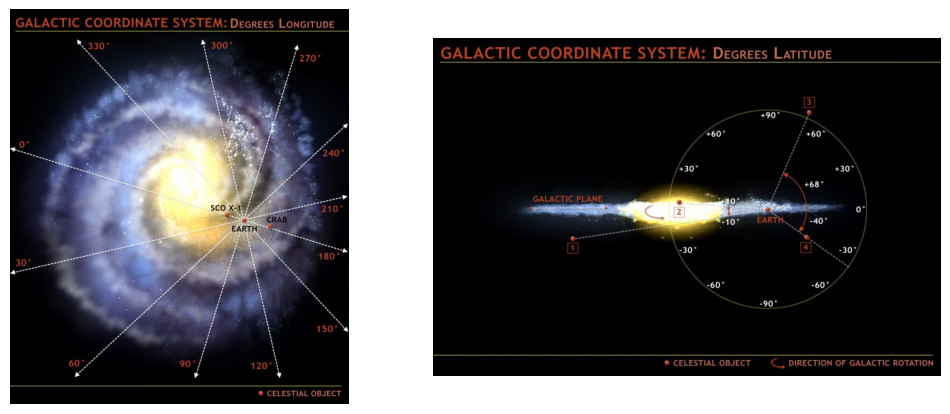

In [50]:
# read images
img_1 = mpimg.imread("figures/longitude_diagram_300dpi-768x896.jpg")
img_2 = mpimg.imread("figures/latitude_diagram_300dpi-1024x683.jpg")

# display images
fig, ax = plt.subplots(1, 2, width_ratios=[0.4, 0.6], figsize=(12, 8))
ax[0].imshow(img_1)
ax[0].axis("off")
ax[1].imshow(img_2)
ax[1].axis("off")
plt.show()

In [51]:
print(f"maximum and minimum longitude: {np.max(events.galactic.l.value):.2f} deg, {np.min(events.galactic.l.value):.2f} deg")
print(f"maximum and minimum latitude: {np.max(events.galactic.b.value):.2f} deg, {np.min(events.galactic.b.value):.2f} deg")

maximum and minimum longitude: 233.13 deg, 168.53 deg
maximum and minimum latitude: 13.69 deg, -64.03 deg


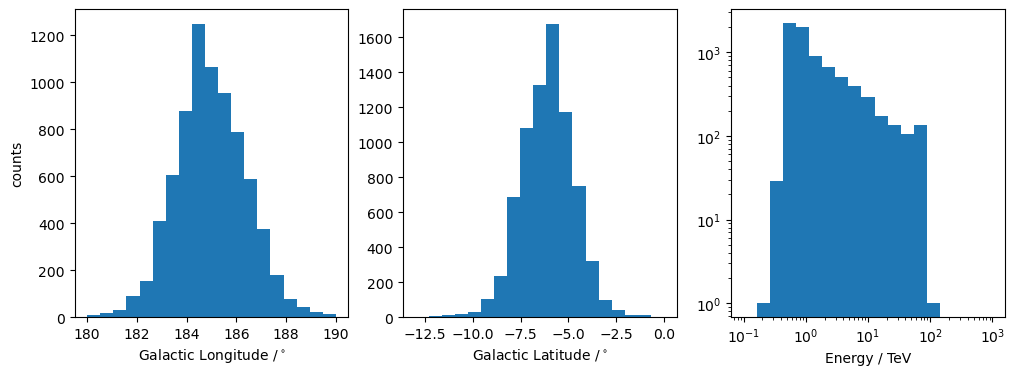

In [52]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

lon_bins = np.linspace(180, 190, 20)
lat_bins = np.linspace(-13, 0, 20)
energy_bins = np.logspace(-1, 3, 20)  # 10 GeV to 10 TeV (events energies are in TeV)

ax[0].hist(events.galactic.l.value, bins=lon_bins)
ax[1].hist(events.galactic.b.value, bins=lat_bins)
ax[2].hist(events.energy.value, bins=energy_bins)

ax[0].set_xlabel("Galactic Longitude " + r"$/\,^{\circ}$")
ax[1].set_xlabel("Galactic Latitude " + r"$/\,^{\circ}$")
ax[2].set_xscale("log")
ax[2].set_yscale("log")
ax[2].set_xlabel("Energy / TeV")
ax[0].set_ylabel("counts")
plt.show()

## 1.2. What is an observation?

Each observation consists of ~20 min of data taking. The data that we will use is already processed and ready for scientific analysis. It is stored in a "fits" file format. A standard digital file format useful for storage of astronomy data (mostly images, but tables as well). For each observation, the information required to produce scientific results is:

- Events table
- Good Time Interval
- Instrument Response Functions

In [54]:
obs = Observation.read(
    "data/hess-dl3-dr1/data/hess_dl3_dr1_obs_id_020136.fits.gz"
)
print(obs)

Observation

	obs id            : 20136 
 	tstart            : 53090.12
	tstop             : 53090.14
	duration          : 1682.00 s
	pointing (icrs)   : 228.6 deg, -58.8 deg

	deadtime fraction : 9.6%



Instead of looking at only one observation we can also load all the data at once using the DataStore class of Gammapy. The DataStore object allows to read all the fits files in a directory, provided that we have generated and included in the folder two auxiliary files after we have produced the DL3 data: the obs-index.fits.gz and the hdu-index.fits.gz. They are summary files listing all observations inside a directory.

In [57]:
data_store = DataStore.from_dir("data/hess-dl3-dr1")
data_store.info()

Data store:
HDU index table:
BASE_DIR: data/hess-dl3-dr1
Rows: 630
OBS_ID: 20136 -- 47829
HDU_TYPE: [np.str_('aeff'), np.str_('bkg'), np.str_('edisp'), np.str_('events'), np.str_('gti'), np.str_('psf')]
HDU_CLASS: [np.str_('aeff_2d'), np.str_('bkg_3d'), np.str_('edisp_2d'), np.str_('events'), np.str_('gti'), np.str_('psf_table')]


Observation table:
Observatory name: 'N/A'
Number of observations: 105



From there we can extract a list of observations, choosing from the available observation IDs or loading all observations inside the directory we specified.

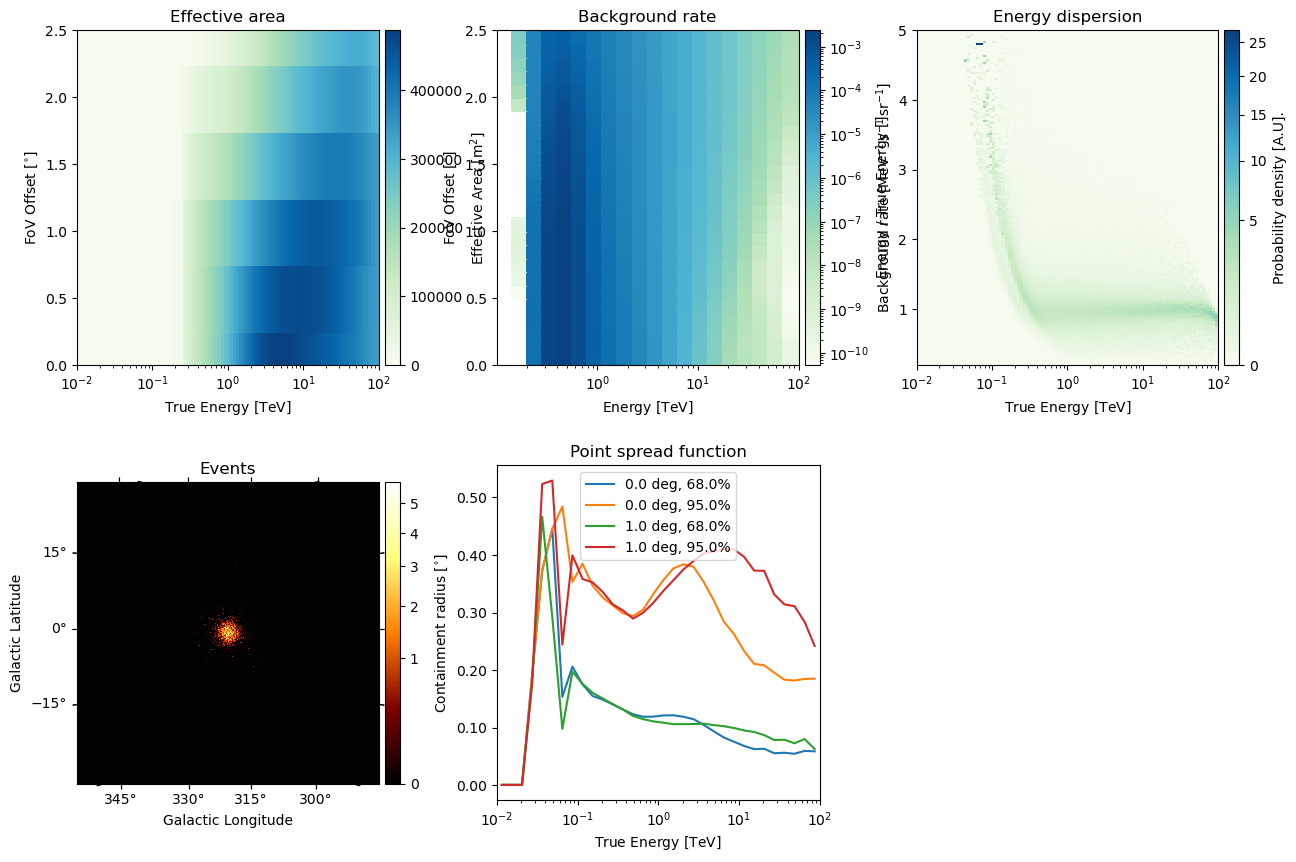

In [58]:
#obs_ids = [23523, 33798, 33799]
#observations = data_store.get_observations(obs_ids)

observations = data_store.get_observations(required_irf=["psf", "aeff", "edisp"])

observations[0].peek()

We can also preview an excerpt from the observation table, get a single observation or select and peek events. We have done most of this before but using less general classes of Gammapy.

In [59]:
display(data_store.obs_table[:2][["OBS_ID", "DATE-OBS", "RA_PNT", "DEC_PNT", "OBJECT"]])

OBS_ID,DATE-OBS,RA_PNT,DEC_PNT,OBJECT
,,deg,deg,
int64,bytes10,float32,float32,bytes18
20136,2004-03-26,228.6125,-58.771667,MSH15-52
20137,2004-03-26,228.6125,-59.771667,MSH15-52


In [60]:
obs = data_store.obs(23523)

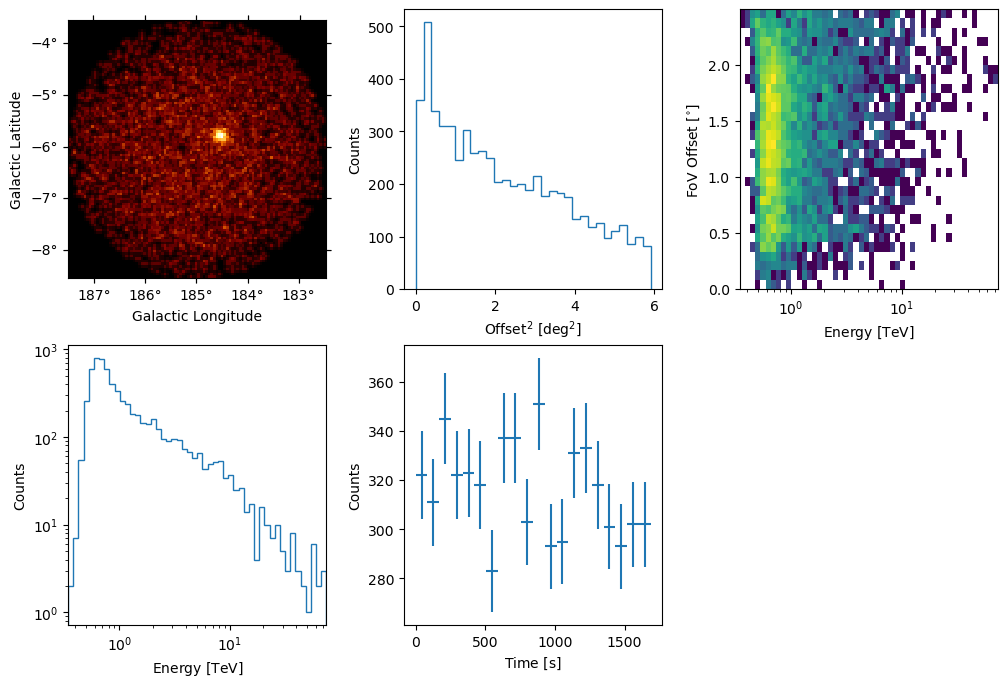

In [61]:
obs.events.select_offset([0,2.5] * u.deg).peek()

## 1.3. Instrument Response Functions

An IRF is a characterisation of the telescope performance. It is the second component of our standardised, high-level, gamma-ray data. The IRF parameterises the response of the systems, meaning, it tells us how estimated quantities relate to real one (e.g. reconstructed vs true energy). It also gives us the possibility to convert observables from the "detector world" (e.g. counts) to the "physical world" (e.g. fluxes).

"The instrument response functions (IRFs) provide a mathematical description that links the reconstructed photon arrival direction 𝑝′, energy 𝐸′ and trigger time 𝑡′ of an event to the true incident direction 𝑝, energy 𝐸 and time 𝑡 of a photon."

![IRFs](figures/irfs.jpg)

Given the real emission of the source, we indirectly detect the emission through the telescope, which is more or less efficient depending on energy, resolution, etc. From the recorded and reconstructed information we obtain, we have to recover the real emission. This requires knowing the telescope performance (IRFs). In optical astronomy, the IRFs would be something like the quantum efficiency of the detector.

For IACTs, the IRFs are formed by:
- Effective area
- Energy dispersion matrix
- Point spread function

### 1.3.1. Effective area

It is the effective collection area of the detector (unit: $m^2$). It is the product of the detector collection area times its detection efficiency at true energy $E_{true}$ and position $p_{true}$. The higher this value the better.

<Axes: xlabel='True Energy [$\\mathrm{TeV}$]', ylabel='FoV Offset [$\\mathrm{{}^{\\circ}}$]'>

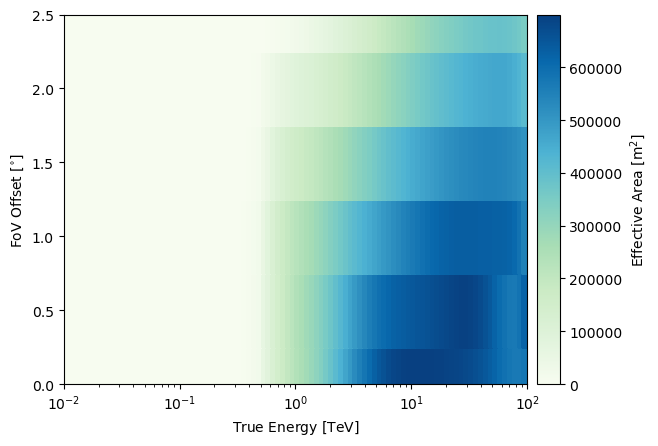

In [62]:
obs.aeff.plot()

This IRF component is a function of the energy and of the offset. As we are observing a small area of the sky, the spatial dependence of the IRF is more conveniently expressed as a function of the detector coordinates (offset from the camera centre rather than sky coordinates, in this case). If the source of our interest sits, for example at $0.4^{\circ}$ or $1^{\circ}$ degrees from the camera centre, we can evaluate the effective area there.

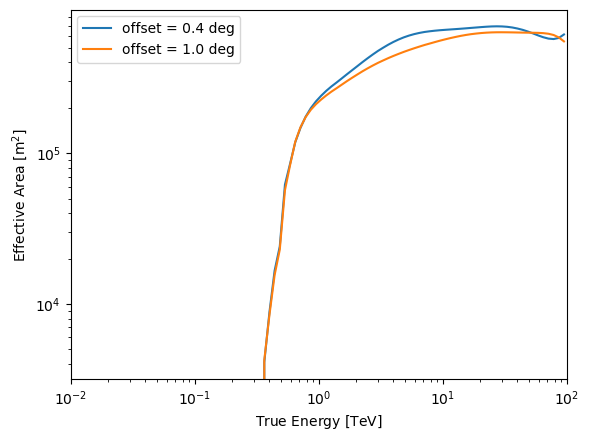

In [63]:
fig, ax = plt.subplots()
obs.aeff.plot_energy_dependence(ax=ax, offset=[Angle("0.4 deg"), Angle("1 deg")])
ax.set_yscale("log")
plt.show()

### 1.3.2. Energy dispersion matrix

It gives the probability of reconstructing the photon at energy $E$ when the true energy is $E_{true}$ and the true position $p_{true}$. The less dispersion the better. Too see some quick overview plots we can also use the peek function in Gammapy.

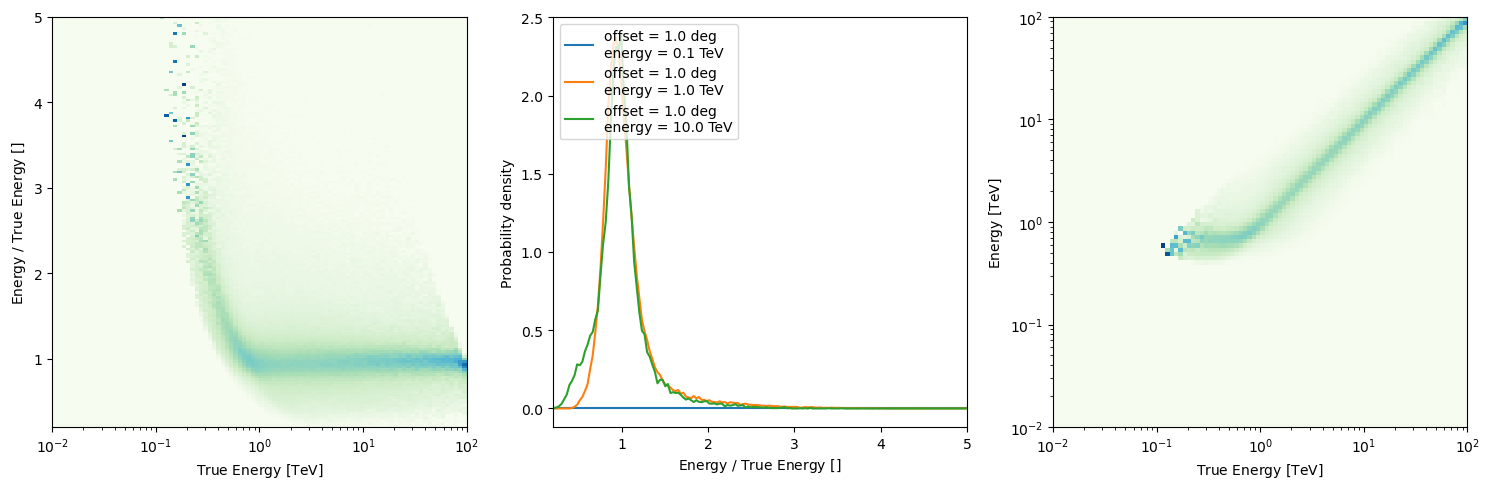

In [64]:
obs.edisp.peek()

### 1.3.3. Point spread function

It gives the probability of measuring a direction $p$ when the true direction is $p_{true}$ and the true energy is $E_{true}$. Smaller radius values are better for the PSF, because they indicate a better separation power of the system.

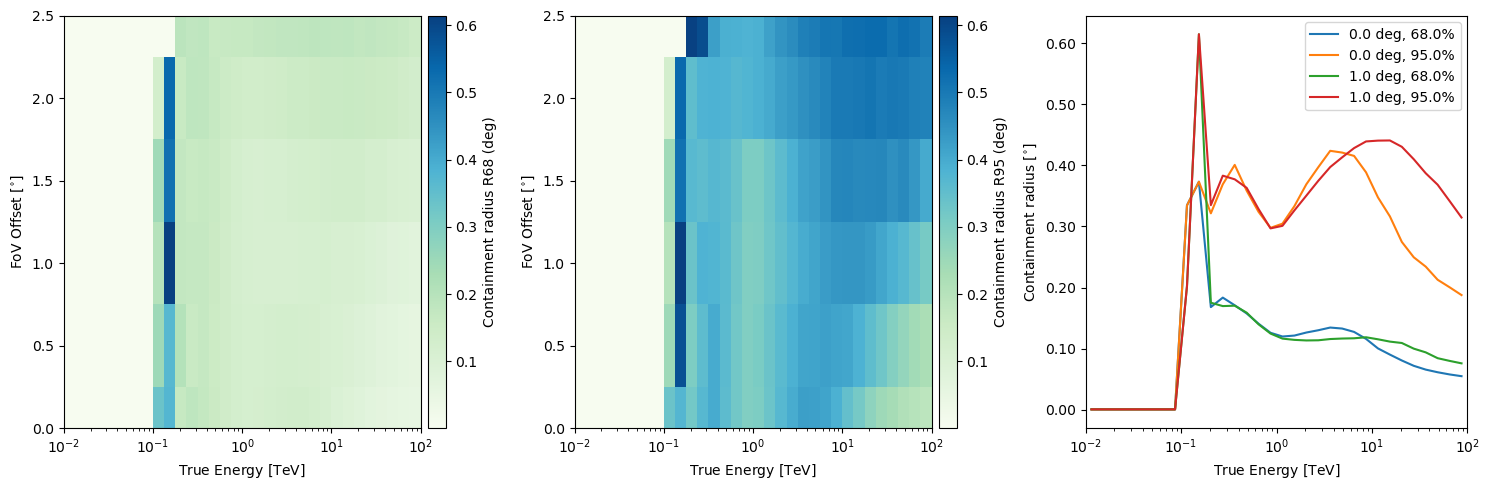

In [65]:
obs.psf.peek()

# 2. Exercises for this tutorial

Among the publicly available data there is also some Crab Nebula data from the MAGIC telescopes (you can find it under data/magic on the git repository). You will need that data for the following excercises.

## 2.1.
Open a MAGIC and a H.E.S.S. observation of the Crab Nebula (you can check which observation ID belongs to which source on the last three pages of [this](https://www.mpi-hd.mpg.de/HESS/pages/dl3-dr1/hess_dl3_dr1.pdf) document). Select a circular region of $0.2^{\circ}$ around the nominal coordinates of the Crab Nebula following the instructions below. Using both the MAGIC and the H.E.S.S. observations, create a histogram of the counts vs energy for the events contained in that region (plot both counts histograms in the same region). Here follows an example of how to select events from an EventList object inside a circular region (in this example there will be no events left after the selection because the observation run that is used is not corresponding to the coordinates of the object _Markarian 501_):

```
events = EventList.read(
    "hess-dl3-dr1/data/hess_dl3_dr1_obs_id_033792.fits.gz"
)
coordinates = SkyCoord.from_name("Markarian 501")
on_region = CircleSkyRegion(center=coordinates, radius=0.5 * u.deg)
on_events = events.select_region(on_region)
```

## 2.2.
Compare the effective areas of the MAGIC and H.E.S.S. observations at an offset of $0.4^{\circ}$ degree.